In [33]:
%matplotlib inline

from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

import seaborn as sns
sns.set(font_scale=2)
sns.set_style("ticks")

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

def load_scores(experiment):
    with open(os.path.join(experiment, "run.log")) as log_f:
        groups = {}
        group = {}
        step = 0
        for line in log_f:
            if " [step] " in line:
                groups[step] = group
                group = {}
                step = int(line.split()[-1])
            elif " [task] " in line:
                parts = line.split()
                task = parts[4]
                score = float(parts[6])
                assert task not in group
                group[task] = score
        groups[step] = group
        return groups
    
def plot_means(title, experiments, n_tasks, fig_name):
    max_step = 3000000
    #for experiment, style in experiments.items():
    for experiment, style, downsample in experiments:
        label, color, ls = style
        steps = []
        means = []
        scores = load_scores(experiment)
        keys = sorted(scores.keys())
        keys = keys[::downsample]
        for step in keys:
            block = scores[step]
            mean = sum(block.values()) / n_tasks
            steps.append(step)
            means.append(mean)
        plt.plot(steps, means, label=label, color=color, ls=ls)
        last_mean = [m for s, m in zip(steps, means) if s >= max_step][0]
        plt.text(max_step * 1.02, last_mean - 0.02, label, size="smaller")
    #plt.legend(loc=2)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.title(title, y=1.05)
    plt.xlim([0, max_step])
    plt.ylim([0, 1])
    plt.xlabel("Episode")
    plt.ylabel("Avg.\\ reward", labelpad=10)
    plt.tight_layout()
    plt.gcf().subplots_adjust(right=0.80)
    plt.savefig(fig_name)
    plt.show()
    
def plot_path(title, experiments, fig_name):
    for experiment, style in experiments:
        label, color, ls = style
        steps = []
        means = []
        counter = 0
        last_mean = last_step = None
        with open("path/run_final_" + experiment + ".log") as log_f:
            for line in log_f:
                if "|" not in line:
                    continue
                msg = line.split("|")[1]
                words = msg.split()
                if words[0] == "NumTrajs":
                    last_step = int(words[1])
                    counter += 50000
                    #counter += last_step
                    steps.append(counter)
                if words[0] == "AverageReturn":
                    last_mean = float(words[1])
                    #means.append(last_mean)
                if last_mean and last_step:
                    means.append(np.log(last_mean * last_step / 50000))
                    last_mean = last_step = None
        steps = steps[::50]
        _means = []
        for i in range(0, len(means), 50):
            _means.append(np.mean(means[i:i+59]))
        means = _means
        plt.plot(steps, means, label=label, color=color, ls=ls)
        last_mean = means[-1]
        plt.text(2.35e7, last_mean - 0.02, label, size="smaller")
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
    plt.title(title, y=1.05)
    plt.xlabel("Episode")
    #plt.xlim([0, 2.25e7])
    plt.ylabel("Avg.\\ reward", labelpad=10)
    plt.tight_layout()
    plt.gcf().subplots_adjust(right=0.80)
    plt.savefig(fig_name)
    plt.show()
    
def plot_wins(title, experiments, fig_name):
    for experiment, style in experiments:
        label, color, ls = style
        steps = []
        means = []
        counter = 0
        running_wins = 0
        running_trajs = 0
        with open("path/run_final_" + experiment + ".log") as log_f:
            for line in log_f:
                if "|" in line:
                    msg = line.split("|")[1]
                    words = msg.split()
                    if words[0] == "Iteration":
                        it = int(words[1])
                        if it > 0 and it % 100 == 0:
                            steps.append(it)
                            if running_wins == 0:
                                means.append(0)
                            else:
                                means.append(1. * running_wins / running_trajs)
                            running_wins = 0
                            running_trajs = 0
                    if words[0] == "NumTrajs":
                        running_trajs += int(words[1])
                elif "WIN" in line:
                    running_wins += 1
        plt.plot(steps, means, label=label, color=color, ls=ls)
        last_mean = means[-1]
        plt.text(steps[-1] * 1.04, last_mean - 0.002, label, size="smaller")
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
    plt.title(title, y=1.05)
    plt.xlabel("Timestep")
    plt.ylabel("Task completion", labelpad=10)
    plt.tight_layout()
    plt.gcf().subplots_adjust(right=0.80)
    plt.savefig(fig_name)
    plt.show()
    
TASK_LENS = {
    "make[stick]": 2,
    "make[cloth]": 2,
    "make[rope]": 2,
    "make[plank]": 2,
    "make[bridge]": 3,
    "make[bed]": 4,
    "get[gold]": 4,
    "make[shears]": 4,
    "make[axe]": 4,
    "get[gem]": 5,
    'go[LL]': 2, 
    'go[URU]': 3, 
    'go[LLD]': 3, 
    'go[LD]': 2, 
    'go[UL]': 2, 
    'go[DRU]': 3, 
    'go[RD]': 2, 
    'go[LUR]': 3, 
    'go[RDD]': 3, 
    'go[UR]': 2
}
MAX_TASK_LEN = 5
    
def plot_hist(title, experiment, n_tasks, fig_name):
    max_step = 3000000
    index = {}
    scores = load_scores(experiment)
    x = list(sorted(scores.keys()))
    y = [[0 for _x in range(len(x))] for _t in range(n_tasks)]
    for ix, _x  in enumerate(x):
        for k in scores[_x]:
            if k not in index:
                index[k] = len(index)
            i = index[k]
            y[i][ix] = scores[_x][k] / n_tasks
            
    labels = []
    colors = []
    for k, v in sorted(index.items(), key=lambda x: x[1]):
        labels.append(k)
        #colors.append(np.ones(3) * TASK_LENS[k] / MAX_TASK_LEN * 0.9)
        colors.append(np.asarray([0.5, 0.5, 1]) * TASK_LENS[k] / MAX_TASK_LEN * 0.9)
            
    plt.stackplot(x, y, labels=labels, colors=colors, edgecolor=(1, 1, 1))
            
    #plt.legend(loc=2)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.title(title, y=1.05)
    plt.xlim([0, max_step])
    plt.ylim([0, 1])
    plt.xlabel("Episode", labelpad=10)
    plt.ylabel("Avg.\\ reward", labelpad=10)
    plt.tight_layout()
    plt.gcf().subplots_adjust(right=0.80)
    plt.savefig(fig_name)
    plt.show()

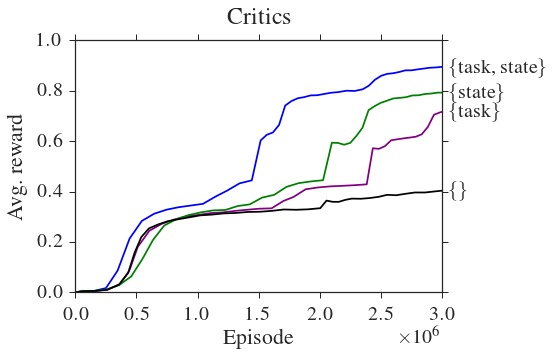

In [2]:
plot_means("Critics",
    [
     ("craft_modular_state-baseline", ("\{task, state\}", "b", "-"), 1),
     #("craft_modular_no-curriculum-lmax", ("\{task, state\}", "r", "-")),
     ("craft_modular_task-baseline", ("\{task\}", "purple", "-"), 1),
     ("craft_modular_common-baseline", ("\{state\}", "green", "-"), 1),
     ("craft_modular_common-nostate-baseline", ("\{\}", "k", "-"), 1)
    ],
    10,
    "critics.pdf")

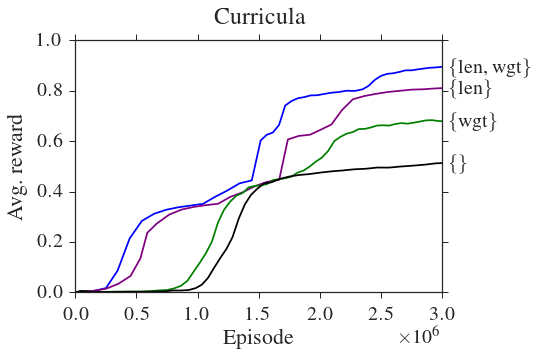

In [3]:
plot_means("Curricula",
    [
     ("craft_modular_state-baseline", ("\{len, wgt\}", "blue", "-"), 1),
     ("craft_modular_no-curriculum-weighting", ("\{len\}", "purple", "-"), 1),
     ("craft_modular_no-curriculum-lmax", ("\{wgt\}", "green", "-"), 1),
     ("craft_modular_no-curriculum", ("\{\}", "k", "-"), 1)
    ],
    10,
    "curricula.pdf")

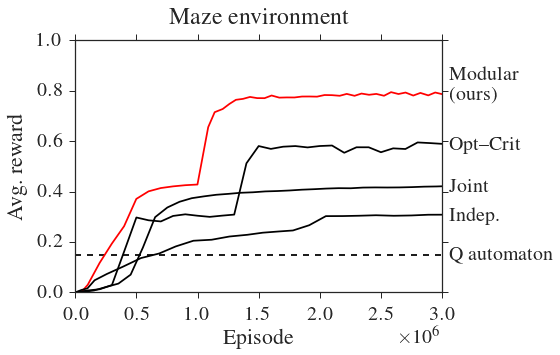

In [4]:
plt.axhline(y=.15, label="Q automaton", color="k", ls="--")
plt.text(3000000 * 1.02, .15 - 0.02, "Q automaton", size="smaller")
plot_means("Maze environment",
    [
     ("light_modular", ("Modular\n(ours)", "r", "-"), 1),
     ("light_joint-feat-plan", ("Joint", "k", "-"), 1),
     ("light_indep", ("Indep.", "k", "-"), 1),
     ("light_unsup_unordered", ("Opt--Crit", "k", "-"), 10)
    ],
    10,
    "maze_all.pdf")

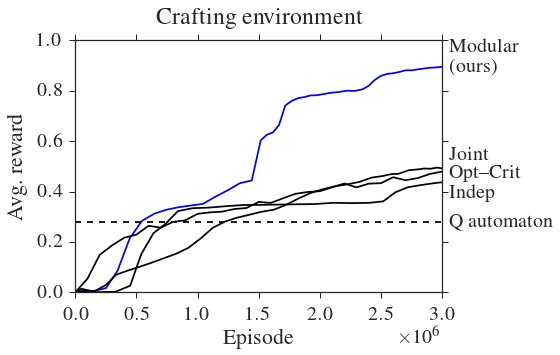

In [5]:
plt.axhline(y=.28, label="Q automaton", color="k", ls="--")
plt.text(3000000 * 1.02, .28 - 0.02, "Q automaton", size="smaller")

plt.text(3000000 * 1.02, .53, "Joint", size="smaller")
plt.text(3000000 * 1.02, .38, "Indep", size="smaller")

plot_means("Crafting environment",
    [
     ("craft_modular_state-baseline", ("Modular\n(ours)", "b", "-"), 1),
     ("craft_joint-feat-plan", ("", "k", "-"), 1),
     ("craft_indep", ("", "k", "-"), 1),
     ("craft_unsup_unordered", ("Opt--Crit", "k", "-"), 10)
    ],
    10,
    "craft_all.pdf")

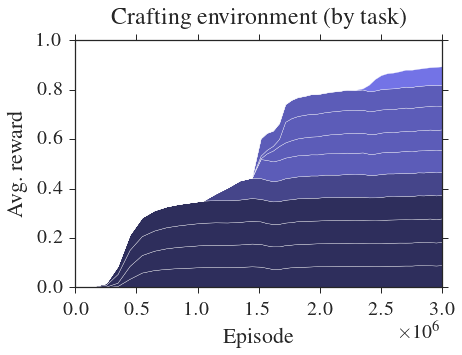

In [6]:
plot_hist("Crafting environment (by task)", "craft_modular_state-baseline", 10, "craft_bytask.pdf")
#plot_hist("Crafting environment (by task)", "craft_modular_no-curriculum-weighting", 10)

In [7]:
#plot_hist("Maze environment (by task)", "light_modular", 10)

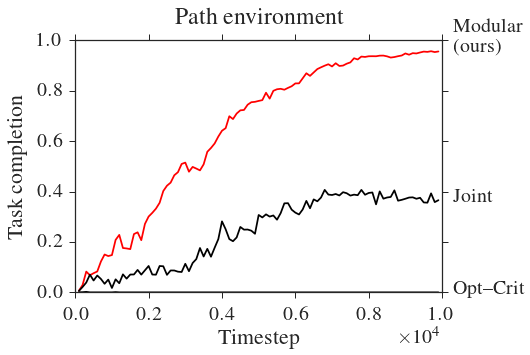

In [36]:
plot_wins("Path environment",
    [
     ("modular", ("Modular\n(ours)", "r", "-")),
     #("indep", ("Indep.", "k", "-")),
     ("joint", ("Joint", "k", "-")),
     ("optcrit", ("Opt--Crit", "k", "-"))
    ],
    "path_win.pdf")

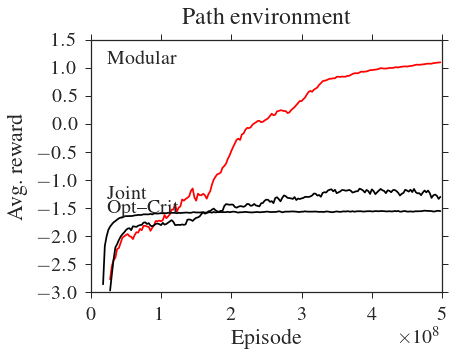

In [35]:
plot_path("Path environment",
    [
     ("modular", ("Modular", "r", "-")),
     #("indep", ("Indep.", "k", "-")),
     ("joint", ("Joint", "k", "-")),
     ("optcrit", ("Opt--Crit", "k", "-"))
    ],
    "path_all.pdf")